Robertas Buračevskis, 2110543, III PS, 1gr, 2užd.

In [ ]:
!pip install openimages

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 56.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.2/82.2 kB 8.9 MB/s eta 0:00:00


In [ ]:
import os
import glob
import PIL
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from openimages.download import download_dataset
from PIL import Image

Transformations for Training and Testing

In [ ]:
transformTrain = transforms.Compose([
  transforms.RandomHorizontalFlip(),
  transforms.Resize((128, 128)),
  transforms.Pad(2), #adding 2 pixel black bars
  transforms.RandomCrop((128,128)),
  transforms.RandomRotation(10),
  transforms.ToTensor()
])
transformTest = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(), ])

Downloading images

In [ ]:
data_dir = "data"
number_for_samples = 500
classes = ["Jellyfish", "Bee", "Banana"]
classes_file_path = "./imagenet.txt"

with open(classes_file_path) as cf:
  class_list = [line.split('\'')[1].lower().split(", ") for line in cf.readlines()]

class_indexes = { c: [idx for idx, s in enumerate(class_list) if c.lower() in s][0] for c in classes }

if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    download_dataset(data_dir, classes, limit=number_for_samples)
else:
  print("Dataset already exists")

100%|██████████| 54/54 [00:05<00:00, 10.66it/s]


File object with all of the files loaded according to class

In [ ]:
images_dir = "./data"
files = { c : [] for c in classes} #dictionary
for c in classes:
  files[c] = glob.glob(images_dir + "/{}/images/*.jpg".format(c.lower())) #suskirsto pagal klases

Dividing images into training and testing segments. 80% Training and 20% Testing

In [ ]:
trainFiles = {c : [] for c in classes}
testFiles = {c : [] for c in classes}

for c in classes:
    trainFiles[c] = files[c][:int(len(files[c]) * 0.8)]
    testFiles[c] = files[c][-int(len(files[c]) * 0.2):]

Creating CustomDataset

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, files, preprocess):
        self.files = files #saving as attribute
        self.preprocess = preprocess #saving as attribute


        self.fileLen = {c : [] for c in classes} #dictionary inicialization
        for c in classes: #einama per kiekviena klase is classes ir priskiriama files[c] klase
          self.fileLen[c] = len(files[c])

        self.all_files = [item for sublist in files.values() for item in sublist] #konkatenacija


        self.labels = np.zeros(len(self.all_files)) #labels uzpildo nuliais
        self.labels[self.fileLen[classes[0]]:self.fileLen[classes[0]]+self.fileLen[classes[1]]] = 1 #labels uzpildo 1
        self.labels[self.fileLen[classes[0]]+self.fileLen[classes[1]]:] = 2 #labels uzpildo 2


        self.order =  [x for x in np.random.permutation(len(self.labels))] #sumaisomi duomenys
        self.all_files = [self.all_files[x] for x in self.order]
        self.labels = [self.labels[x] for x in self.order]


    def __len__(self): #grazina bendra failu skaiciu
        return (len(self.all_files))

    def __getitem__(self, index): #paima elemento kelia ir labeli pagal duoda indeksa
        file = self.all_files[index]

        image = Image.open(file).convert('RGB')
        process_image = self.preprocess(image)

        label = self.labels[index]
        return (process_image, label)

Creating training and testing datasets

In [ ]:
train_dataset = CustomDataset(trainFiles, transformTrain)
test_dataset = CustomDataset(testFiles, transformTest)

Dataloaders initialization

In [ ]:
num_workers = 2
batch_size = 8
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

Showing img example

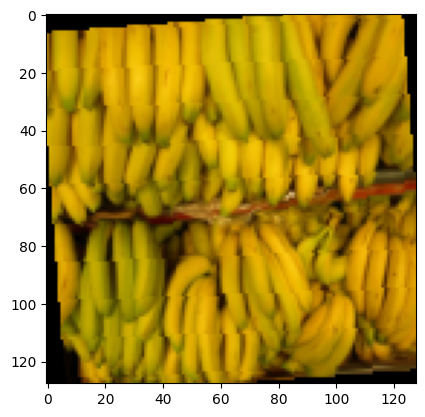

In [ ]:
img = train_dataset[0][0].numpy()
plt.imshow(img.transpose(1,2,0));

Something similar to "Bigger convolution network"

In [ ]:
class CNN(nn.Module):
    def __init__(self, classes_count):
        super(CNN, self).__init__() #paveldejimas nn.Module klases
        self.conv1 = nn.Conv2d(classes_count, 16, 5) #first layer 16out, 5x5
        self.pool = nn.MaxPool2d(2, 2) #pooling layer, 2x2, step 2 (mazina isvesties matmenis)
        self.conv2 = nn.Conv2d(16, 32, 5) #second layer, 32out, 5x5
        self.fc1 = nn.Linear(32 * 29 * 29, 120) #fully connected layer, vercia i vienmati vektoriu, iki out 120
        self.fc2 = nn.Linear(120, 84) #second fully connected layer, iki out 84
        self.fc3 = nn.Linear(84, classes_count) #mazinimas iki classes_count

    def forward(self, x): #taisykles, kaip duomenys "eina per tinkla"
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 29 * 29) #vertimas i vienmati vektoriu
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
num_classes = 3
net = CNN(num_classes)
print(net)

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=26912, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=3, bias=True)
)


Functions

In [ ]:
def get_acc(outputs, labels): #funkcija skirta accuracy skaiciavimui
    with torch.no_grad(): #neskaiciuojami gradientai (taupomas laikas ir resursai)
        outputLabels = torch.argmax(outputs, 1) #imam didziausia reiksme
        return torch.sum((labels == outputLabels).float())

In [ ]:
def set_to_device(data, device):
    return (d.to(device) for d in data)

In [ ]:
def showElapsedTime(start, end):
  elapsed_time_ms = start.elapsed_time(end)
  elapsed_time_seconds = elapsed_time_ms / 1000
  minutes = int(elapsed_time_seconds // 60)
  seconds = int(elapsed_time_seconds % 60)
  print(f'Elapsed time: {minutes} minutes {seconds} seconds')

Defining training sequence

In [ ]:
DEVICE = 'cuda'

start = torch.cuda.Event(enable_timing=True) #skaiciavimams
end = torch.cuda.Event(enable_timing=True)

N_train = len(train_dataset) #datasetu dydziai
N_test = len(test_dataset)

finalTestPredictions = {}
finalTestLabels = {}


def train(network, n_epochs, lr): #lr = learning rate
  global finalTestPredictions
  global finalTestLabels
  network.to(DEVICE)
  start.record()

  optimizer = torch.optim.Adam(network.parameters(), lr=lr)  #pritaiko mokymo greiti individualiai kiekvienam parametrui, efektyvesnis, didelis duomenu rinkinys
  criterion = nn.CrossEntropyLoss()

  for epoch in range(0, n_epochs):

      train_loss = 0.0
      train_acc = 0.0
      test_loss = 0.0
      test_acc = 0.0

      for i, data in enumerate(train_loader, 0):
          images, labels = set_to_device(data, DEVICE)

          optimizer.zero_grad()
          outputs = net(images)

          loss = criterion(outputs, labels.long())

          train_loss += loss.item() * images.size(0)
          train_acc += get_acc(outputs, labels)

          loss.backward() #back propogation, skaiciuoja kiekvieno modelio parametro gradienta (kiek ir kaip ji reikia pakeisti), kad sumazinti lossus
          optimizer.step() #weights update'as

      for data in test_loader:
          with torch.no_grad():
            images, labels = set_to_device(data, DEVICE)
            outputs = net(images)

            loss = criterion(outputs, labels.long())
            test_loss += loss.item() * images.size(0)
            test_acc += get_acc(outputs, labels)


            if epoch == n_epochs - 1:
              finalTestPredictions = outputs
              finalTestLabels = labels


      print('Epoch: {} | Train Loss: {:.6f} | Train Acc: {:.3f} | Test Loss: {:.6f} | Test Acc: {:.3f}'.format(
            epoch,
            train_loss / N_train,
            train_acc / N_train,
            test_loss / N_test,
            test_acc / N_test,
            ))

  end.record()
  torch.cuda.synchronize()

  print('Finished Training')
  torch.save(net.state_dict(), 'trained_model_parameters.pth')
  showElapsedTime(start, end)

Training 50 epochs with different learning rates

In [ ]:
train(net, 30, 1e-3)
train(net, 20, 1e-4)

Epoch: 0 | Train Loss: 0.720341 | Train Acc: 0.593 | Test Loss: 0.764349 | Test Acc: 0.636
Epoch: 1 | Train Loss: 0.666079 | Train Acc: 0.666 | Test Loss: 0.640295 | Test Acc: 0.660
Epoch: 2 | Train Loss: 0.629207 | Train Acc: 0.668 | Test Loss: 0.630321 | Test Acc: 0.708
Epoch: 3 | Train Loss: 0.623613 | Train Acc: 0.695 | Test Loss: 0.640351 | Test Acc: 0.694
Epoch: 4 | Train Loss: 0.577465 | Train Acc: 0.725 | Test Loss: 0.631787 | Test Acc: 0.677
Epoch: 5 | Train Loss: 0.560401 | Train Acc: 0.736 | Test Loss: 0.611865 | Test Acc: 0.746
Epoch: 6 | Train Loss: 0.532477 | Train Acc: 0.763 | Test Loss: 0.633514 | Test Acc: 0.722
Epoch: 7 | Train Loss: 0.527208 | Train Acc: 0.767 | Test Loss: 0.556214 | Test Acc: 0.749
Epoch: 8 | Train Loss: 0.510331 | Train Acc: 0.761 | Test Loss: 0.560434 | Test Acc: 0.759
Epoch: 9 | Train Loss: 0.471679 | Train Acc: 0.790 | Test Loss: 0.583623 | Test Acc: 0.749
Epoch: 10 | Train Loss: 0.470999 | Train Acc: 0.782 | Test Loss: 0.629364 | Test Acc: 0.73

Saving parameters

In [ ]:
torch.save(net.state_dict(), 'trained_model_parameters.pth')

Confusiom matrix

In [ ]:
def printConfusionMatrix(conf_matrix, classes):
  plt.figure(figsize=(8, 6))
  sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=classes, yticklabels=classes)
  plt.xlabel("Predicted Labels")
  plt.ylabel("True Labels")
  plt.title("Confusion Matrix")
  plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

true_values = []
predicted_values = []

with torch.no_grad():
    for data in test_loader:
        images, labels = set_to_device(data, DEVICE)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        true_values.extend(labels.cpu().numpy())
        predicted_values.extend(predicted.cpu().numpy())

accuracy = accuracy_score(true_values, predicted_values)
print(f"Accuracy: {accuracy:.5f}")

recall = recall_score(true_values, predicted_values, average='weighted')
print(f"Recall: {recall:.5f}")

precision = precision_score(true_values, predicted_values, average='weighted')
print(f"Precision: {precision:.5f}")

f1 = f1_score(true_values, predicted_values, average='weighted')
print(f"F1 Score: {f1:.5f}")

Accuracy: 0.79381
Recall: 0.79381
Precision: 0.79708
F1 Score: 0.79466


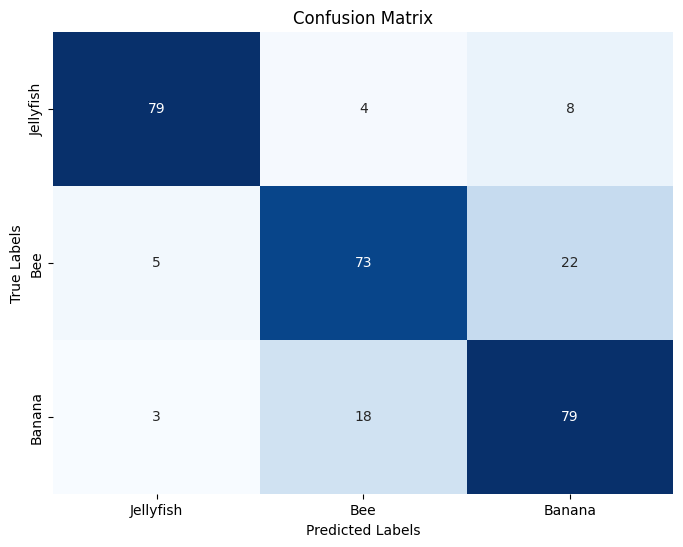

In [ ]:
conf_matrix = confusion_matrix(true_values, predicted_values)
printConfusionMatrix(conf_matrix, classes)

Additional requirement: Create an UI with REST API

In [ ]:
from google.colab.output import eval_js
print(eval_js("google.colab.kernel.proxyPort(5000)"))

https://lu8q3pbbdao-496ff2e9c6d22116-5000-colab.googleusercontent.com/


In [ ]:
from flask import Flask, render_template, request
app = Flask(__name__, template_folder="./")

@app.route("/")
def home():
  return render_template("index.html")

@app.route('/calculate_scores', methods=['POST'])
def calculate_scores():
    if 'image' not in request.files:
        return "No image uploaded", 400

    image_file = request.files['image']
    image = Image.open(image_file.stream)

    input_tensor = transformTest(image).unsqueeze(0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    input_tensor = input_tensor.to(device)

    with torch.no_grad():
      scores = net(input_tensor)
      _, predicted_class = scores.max(1)
      predicted_label = classes[predicted_class]

    return "Predicted class: " + predicted_label

if __name__ == '__main__':
    app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [10/Apr/2024 13:53:28] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [10/Apr/2024 13:53:30] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [10/Apr/2024 13:53:34] "POST /calculate_scores HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [10/Apr/2024 13:53:35] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [10/Apr/2024 13:53:37] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [10/Apr/2024 13:53:38] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [10/Apr/2024 13:53:43] "POST /calculate_scores HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [10/Apr/2024 13:53:44] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [10/Apr/2024 13:53:47] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [10/Apr/2024 13:53:47] "